## Load Libraries

In [2]:
import pandas as pd # dataframes
import numpy as np # algebra & calculus
import nltk # text preprocessing & manipulation

import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

from functools import partial # to reduce df memory consumption by applying to_numeric

color = sns.color_palette() # adjusting plotting style
import warnings
warnings.filterwarnings('ignore') # silence annoying warnings

%matplotlib inline

In [3]:
# aisles
aisles = pd.read_csv('aisles.csv')
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head()

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
# departments
departments = pd.read_csv('departments.csv')
print('Total departments: {}'.format(departments.shape[0]))
departments.head()

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
# products
products = pd.read_csv('products.csv')
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Combine it all together into 1 DataFrame "GOODS"

In [6]:
# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 

goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


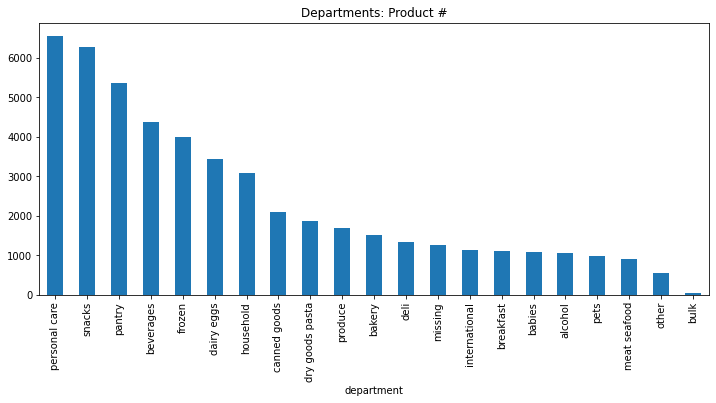

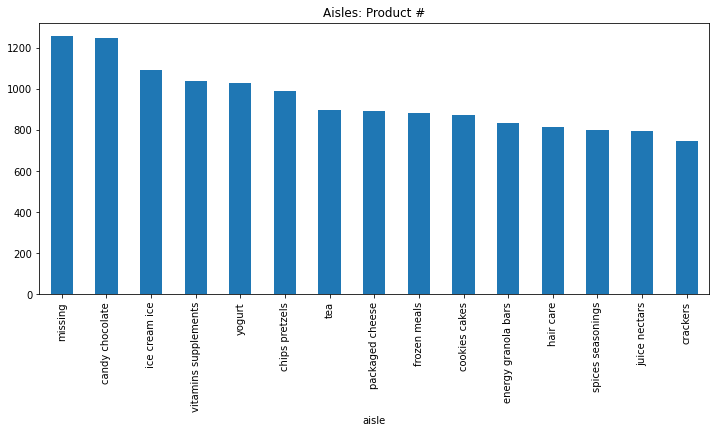

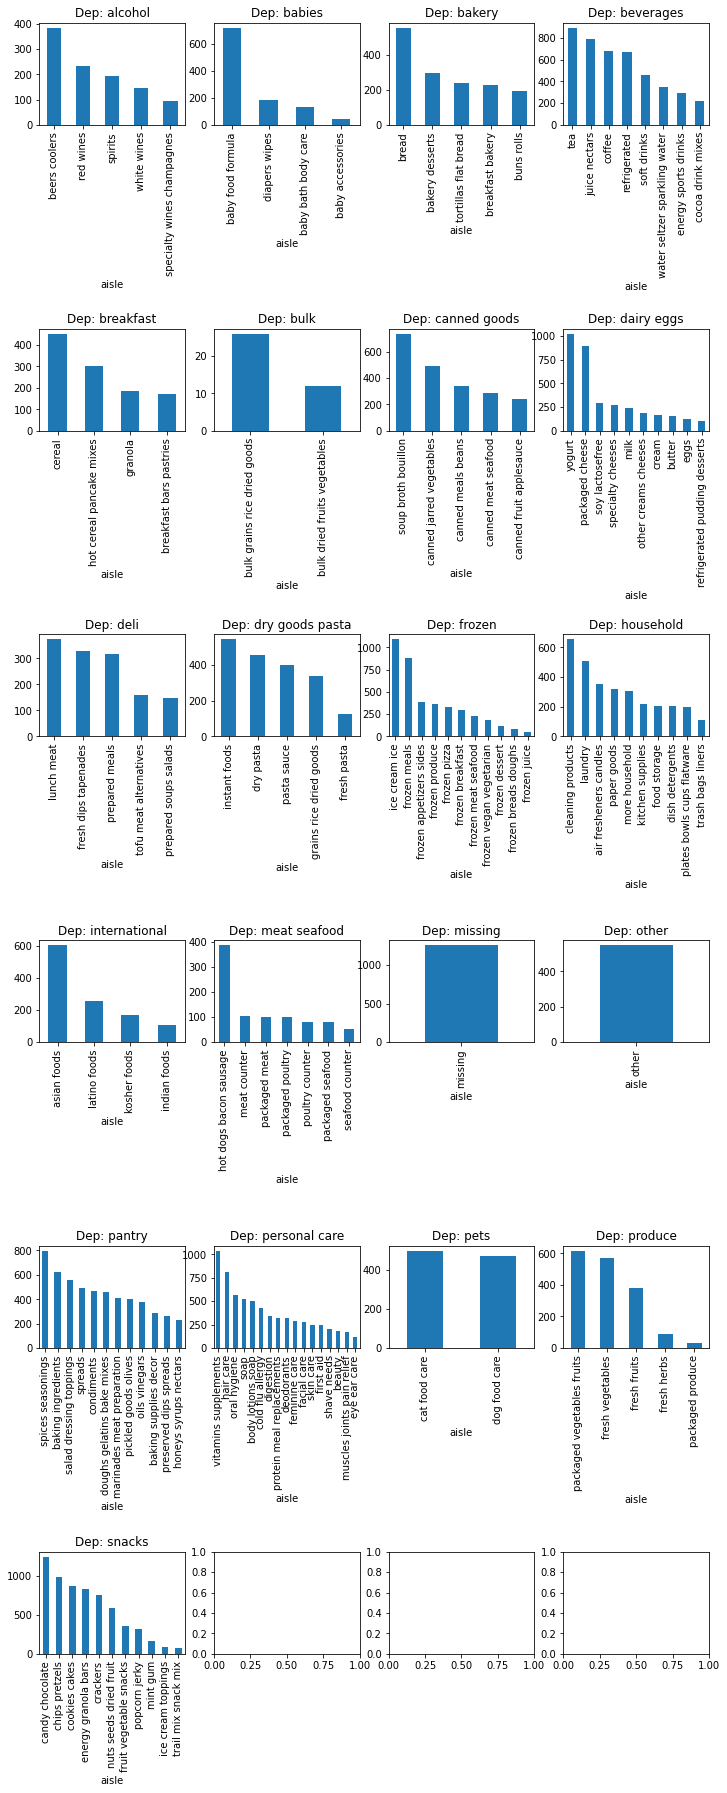

In [7]:
# basic group info (departments)
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Departments: Product #')


# basic group info (top-x aisles)
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Aisles: Product #')

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

## Main Datasets (orders + order details)

In [8]:
# load datasets

# train dataset
op_train = pd.read_csv('order_products__train.csv', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(train): {}'.format(op_train.shape[0]))
op_train.head(10)

Total ordered products(train): 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [9]:
# test dataset (submission)
test = pd.read_csv('sample_submission.csv')
print('Total orders(test): {}'.format(op_train.shape[0]))
test.head()

Total orders(test): 1384617


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [10]:
# prior dataset
op_prior = pd.read_csv('order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(prior): {}'.format(op_prior.shape[0]))
op_prior.head()

Total ordered products(prior): 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
# orders
orders = pd.read_csv('orders.csv', dtype={'order_id': np.int32, 
                                                           'user_id': np.int32, 
                                                           'order_number': np.int32, 
                                                           'order_dow': np.int8, 
                                                           'order_hour_of_day': np.int8, 
                                                           'days_since_prior_order': np.float16})
print('Total orders: {}'.format(orders.shape[0]))
orders.head()

Total orders: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Combine (orders, order details, product hierarchy) into 1 dataframe order_details 


In [12]:
from functools import partial

# merge train and prior together iteratively, to fit into 8GB kernel RAM
# split df indexes into parts
indexes = np.linspace(0, len(op_prior), num=10, dtype=np.int32)

# initialize it with train dataset
order_details = pd.merge(
                left=op_train,
                 right=orders, 
                 how='left', 
                 on='order_id'
        ).apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

# add order hierarchy
order_details = pd.merge(
                left=order_details,
                right=goods[['product_id', 
                             'aisle_id', 
                             'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')),
                how='left',
                on='product_id'
)

print(order_details.shape, op_train.shape)

# delete (redundant now) dataframes
del op_train

order_details.head()

(1384617, 12) (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9,120,16
1,1,11109,2,1,112108,train,4,4,10,9,108,16
2,1,10246,3,0,112108,train,4,4,10,9,83,4
3,1,49683,4,0,112108,train,4,4,10,9,83,4
4,1,43633,5,1,112108,train,4,4,10,9,95,15


In [13]:
%%time
# update by small portions
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=op_prior.iloc[indexes[i]:indexes[i+1], :],
                            right=goods[[
                                'product_id', 
                                 'aisle_id', 
                                 'department_id'
                            ]].apply(partial(pd.to_numeric, 
                                             errors='ignore', 
                                             downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders, 
                     how='left', 
                     on='order_id'
                ) #.apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
        ]
    )
        
print('Datafame length: {}'.format(order_details.shape[0]))
print('Memory consumption: {:.2f} Mb'.format(sum(order_details.memory_usage(index=True, 
                                                                         deep=True) / 2**20)))
# check dtypes to see if we use memory effectively
print(order_details.dtypes)

# make sure we didn't forget to retain test dataset :D
test_orders = orders[orders.eval_set == 'test']

# delete (redundant now) dataframes
del op_prior, orders

Datafame length: 33819106
Memory consumption: 3096.23 Mb
order_id                    int32
product_id                  int32
add_to_cart_order           int16
reordered                    int8
user_id                     int32
eval_set                   object
order_number                int32
order_dow                    int8
order_hour_of_day            int8
days_since_prior_order    float16
aisle_id                    int16
department_id                int8
dtype: object
Wall time: 37.8 s


In [14]:
%%time
# unique orders, product_ordered, users
print('Unique users: {}'.format(len(set(order_details.user_id))))
print('Unique orders: {}'.format(len(set(order_details.order_id))))
print('Unique products bought: {}/{}'.format(len(set(order_details.product_id)), len(goods)))

Unique users: 206209
Unique orders: 3346083
Unique products bought: 49685/49688
Wall time: 14.5 s


In [27]:
# unordered products
unordered = goods[goods.product_id.isin(list(set(goods.product_id) - set(order_details.product_id)))]
print('"Lonesome" products cnt: {}/{}'.format(unordered.shape[0], len(goods)))
unordered.head()

"Lonesome" products cnt: 3/49688


,product_id,product_name,aisle_id,department_id,department,aisle
3629,3630,protein_granola_apple_crisp,57,14,breakfast,granola
7044,7045,unpeeled_apricot_halves_in_heavy_syrup,88,13,pantry,spreads
46624,46625,single_barrel_kentucky_straight_bourbon_whiskey,31,7,beverages,refrigerated


### Popular Products (Bestsellers)

Wall time: 9.83 s


Text(0.5, 0, 'Product Name')

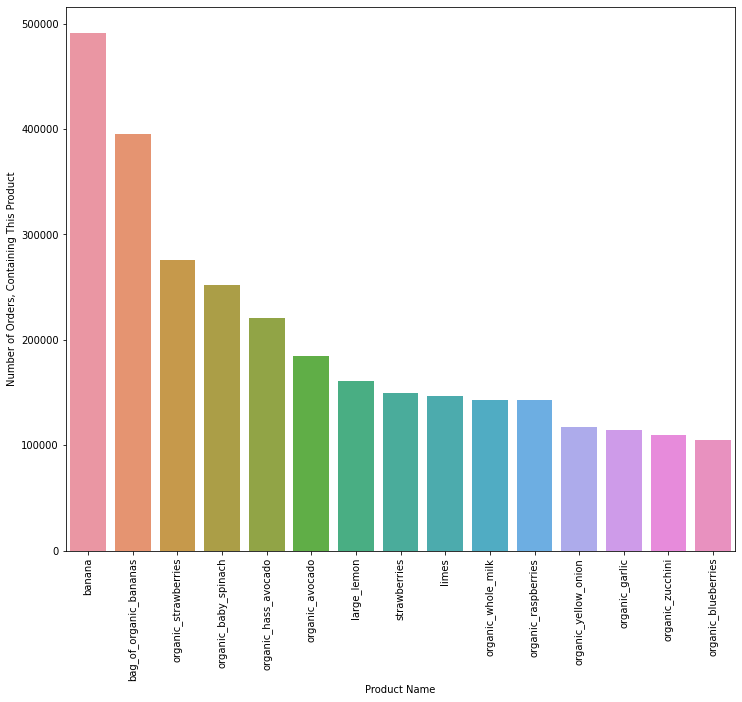

In [15]:
%%time
# popular products (total set, not only train)
top = 15
top_products = pd.merge(
    # to see train: 
    # left=pd.DataFrame(order_details[order_details.eval_set == 'train'].groupby(['product_id'])['order_id']\
    left=pd.DataFrame(order_details.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:top].reset_index('product_id')),
    right=goods,
    how='left')

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=top_products.product_name, y=top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

### Most "Frequently" Bought Products

Wall time: 8.96 s


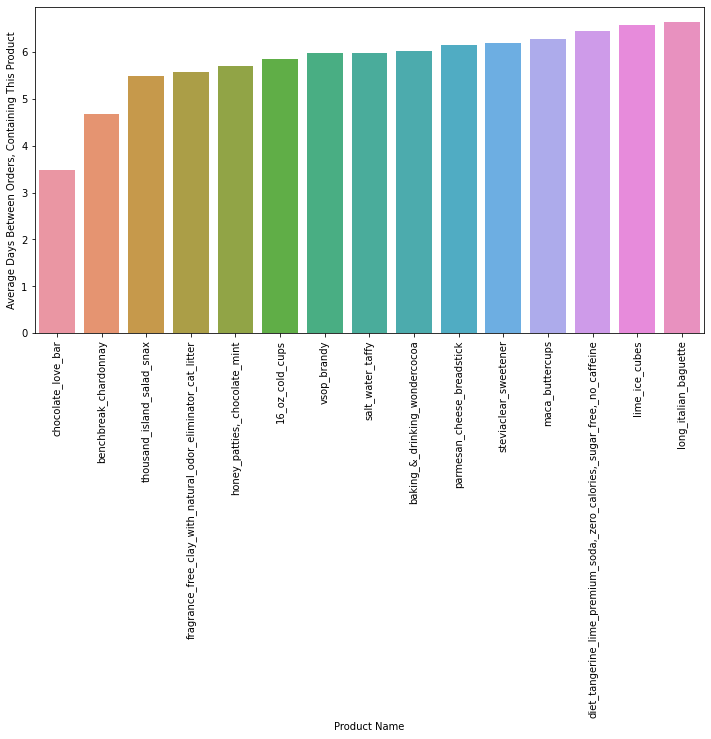

In [16]:
%%time
# most "frequently" bought products (total set, not only train)
# most "frequently" ~ time between orders (within selected customer's orders), 
# that contain that product, is the least 
#(products, which were bought by more than 100 customers, to omit outliers)
top = 15
customer_limit = 100

temp = order_details.groupby(['product_id'])[['days_since_prior_order', 'user_id']]\
.aggregate({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
    left=pd.DataFrame(temp[temp.user_id > customer_limit].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
    right=goods,
    how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.barplot(x=frequent_products.product_name,y=frequent_products.days_since_prior_order)
plt.ylabel('Average Days Between Orders, Containing This Product')
plt.xlabel('Product Name')

del temp

### Orders, Split by Product Count

Most common order contains: 5 products
Wall time: 3.62 s


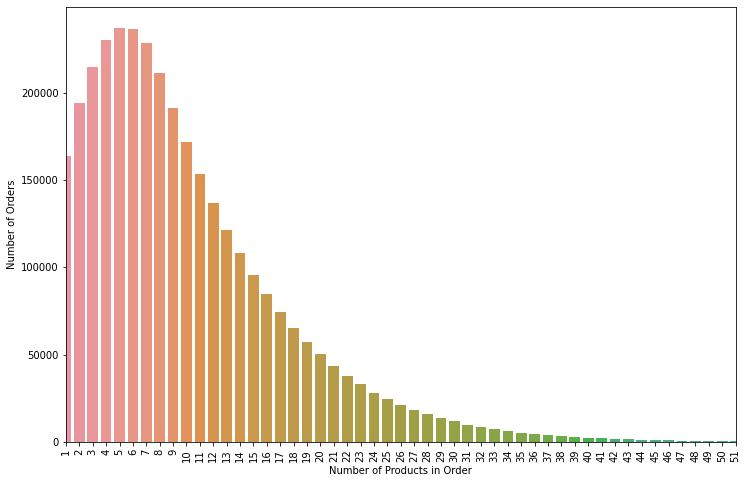

In [48]:
%%time
ord_by_prods = order_details.groupby("order_id")["add_to_cart_order"]\
.aggregate(np.max).reset_index()['add_to_cart_order'].value_counts()

print('Most common order contains: {} products'.format(
    ord_by_prods[ord_by_prods.values == ord_by_prods.max()].index.values[0]))

# plot it
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(x= ord_by_prods.index, y= ord_by_prods.values)
plt.ylabel('Number of Orders')
plt.xlabel('Number of Products in Order')
plt.xlim([0, 50])
pass

### Products with the Highest Reorder Rate

Wall time: 6.87 s


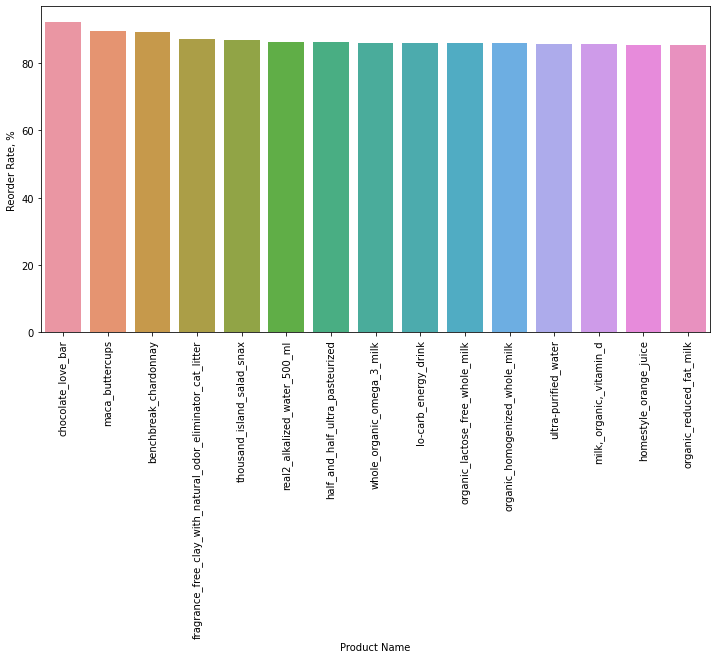

In [17]:
%%time
# consider products, purchased in more than X orders
order_limit = 100
top = 15

mo_products = order_details.groupby('product_id')[['reordered', 'order_id']]\
.aggregate({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_limit].sort_values(['reorder_rate'], 
                                                                           ascending=False)[:top]

mo_products = pd.merge(
    left=mo_products,
    right=goods,
    on='product_id')
mo_products

# plot it
plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=mo_products.product_name,y= mo_products.reorder_rate*100)
plt.ylabel('Reorder Rate, %')
plt.xlabel('Product Name')
pass

### Orders, Split by Day of Week

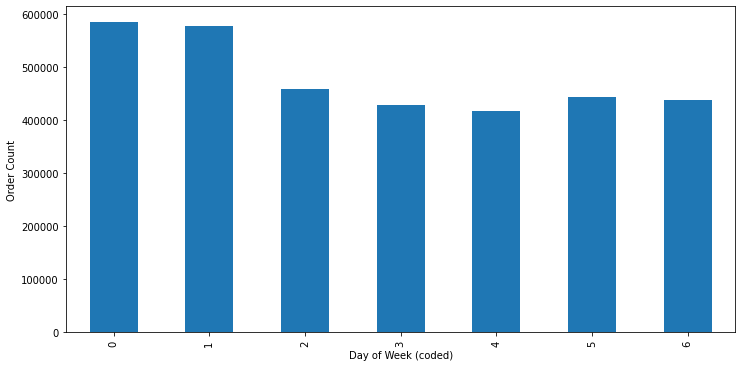

In [18]:
plt.figure(figsize=(12,6))
order_details.groupby('order_dow')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Day of Week (coded)')
pass

### Orders, Split by Hour

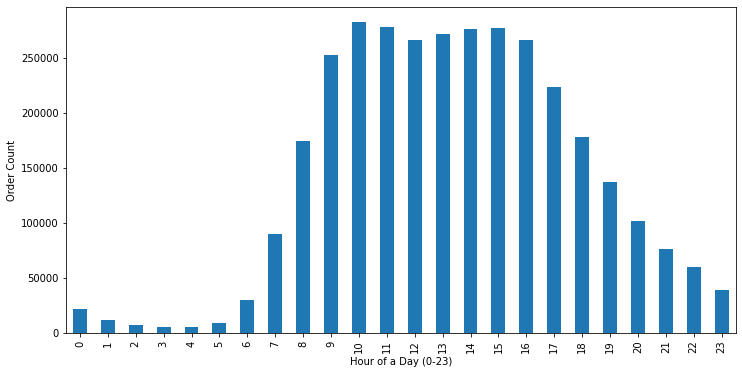

In [19]:
plt.figure(figsize=(12,6))
order_details.groupby('order_hour_of_day')['order_id'].apply(lambda x: 
                                                             len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Hour of a Day (0-23)')
pass

### Most Popular Departments

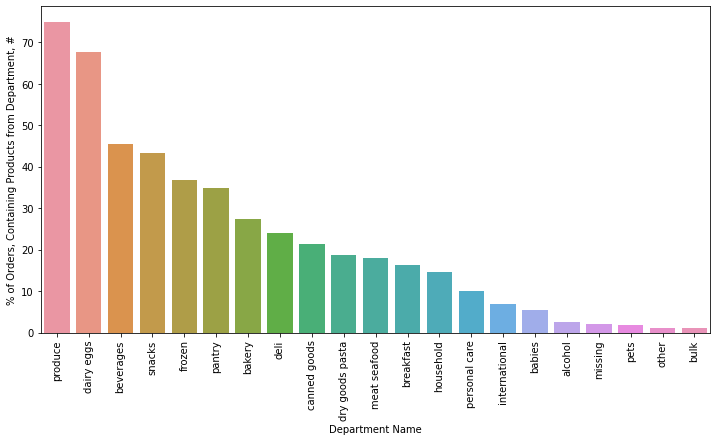

In [20]:
pop_dep = pd.merge(
    left=order_details.groupby('department_id')['order_id'].apply(lambda x: 
                                                                  len(x.unique())).reset_index(),
    right=goods[['department_id', 'department']].drop_duplicates(),
    how='inner',
    on='department_id'
).sort_values(['order_id'], ascending=False)

# plot it
total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=pop_dep.department,y= pop_dep.order_id / total_orders * 100)
plt.ylabel('% of Orders, Containing Products from Department, #')
plt.xlabel('Department Name')
pass

### Most Popular Aisles

Wall time: 8.24 s


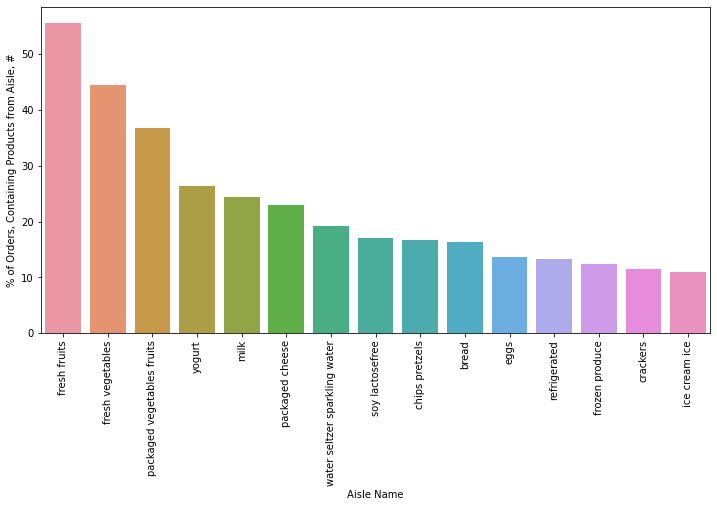

In [21]:
%%time
pop_ais = pd.merge(
    left=order_details.groupby('aisle_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=goods[['aisle_id', 'aisle']].drop_duplicates(),
    how='inner',
    on='aisle_id'
).sort_values(['order_id'], ascending=False)[:top]

# plot it
total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=pop_ais.aisle,y= pop_ais.order_id / total_orders * 100)
plt.ylabel('% of Orders, Containing Products from Aisle, #')
plt.xlabel('Aisle Name')
pass

### Distribution of Order Count per User

Most common user made: 4 purchases
Wall time: 15.9 s


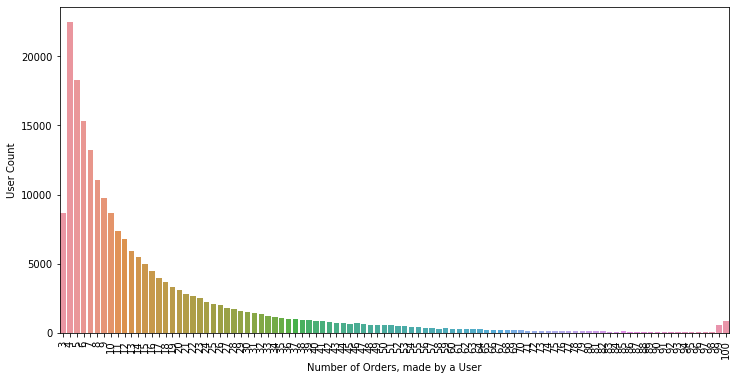

In [22]:
%%time
ocpu = order_details.groupby('user_id')['order_id']\
.apply(lambda x: len(x.unique())).reset_index().groupby('order_id').aggregate("count")

print('Most common user made: {} purchases'.format(
    ocpu[ocpu.user_id == ocpu.user_id.max()].index.values[0]))

plt.figure(figsize=(12, 6))
sns.barplot(x=ocpu.index, y=ocpu.user_id)
plt.xticks(rotation='vertical')
plt.ylabel('User Count')
plt.xlabel('Number of Orders, made by a User')
pass

### Days to Next Order

Most frequently next orders are made once in: 30 days
We clearly see monthly (>=30) and weekly (7) peaks
Wall time: 5.27 s


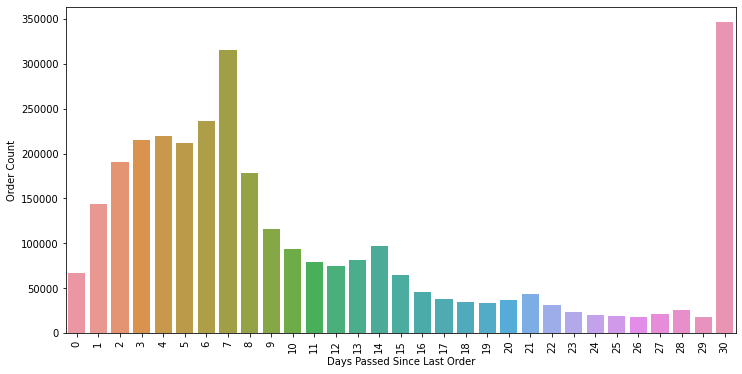

In [23]:
%%time
dtno = order_details.dropna(axis=0, 
                     subset=['days_since_prior_order']).groupby('order_id')['days_since_prior_order']\
.aggregate("mean").reset_index().apply(np.int32).groupby('days_since_prior_order').aggregate("count")

print('Most frequently next orders are made once in: {} days'.format(
    dtno[dtno.order_id == dtno.order_id.max()].index.values[0]))

print('We clearly see monthly (>=30) and weekly (7) peaks')

plt.figure(figsize=(12, 6))
sns.barplot(x=dtno.index,y= dtno.order_id)
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Days Passed Since Last Order')
pass

### Time of last order vs. probability of reorder 

We can see that longer lags leads to lowered probability (new items),
while same day orders tends to have more overlapped product list
Wall time: 4.32 s


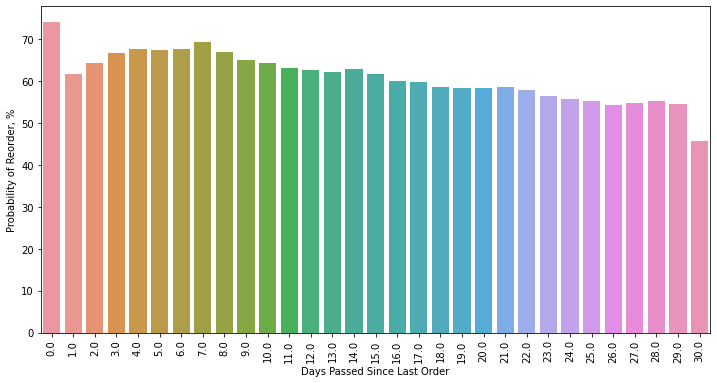

In [24]:
%%time

por = order_details.dropna(axis=0, subset=['days_since_prior_order'])\
.groupby('days_since_prior_order')['reordered'].aggregate("mean").reset_index()

print('We can see that longer lags leads to lowered probability (new items),\
\nwhile same day orders tends to have more overlapped product list')

plt.figure(figsize=(12, 6))
sns.barplot(x= por.days_since_prior_order, y=por.reordered*100)
plt.xticks(rotation='vertical')
plt.ylabel('Probability of Reorder, %')
plt.xlabel('Days Passed Since Last Order')
pass

Wall time: 27.7 s


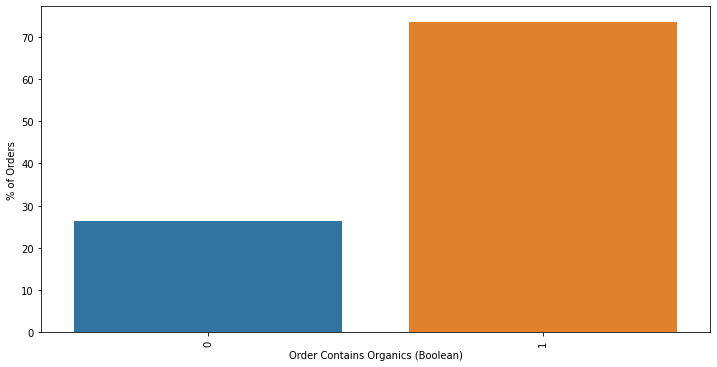

In [25]:
%%time

# share of organic/non-organic products and correspondent orders count
org = pd.merge(
    left=order_details[['product_id', 'order_id']],
    right=goods[['product_id', 'product_name']],
    how='left',
    on='product_id')

org['organic'] = org.product_name.str.contains('organic').astype(np.int8)
org = org.groupby('order_id')['organic'].aggregate("max").value_counts()

# plot it
plt.figure(figsize=(12, 6))
sns.barplot(x=org.index,y=( org / org.sum() * 100) )
plt.xticks(rotation='vertical')
plt.xlabel('Order Contains Organics (Boolean)')
plt.ylabel('% of Orders')
pass